In [15]:
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

audio_path = 'a002_110_120.wav'
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)

print('------ Audio tagging ------')
at = AudioTagging(checkpoint_path=None, device='cuda')
(clipwise_output, embedding) = at.inference(audio)

print('------ Sound event detection ------')
sed = SoundEventDetection(checkpoint_path=None, device='cuda')
framewise_output = sed.inference(audio)


------ Audio tagging ------
Checkpoint path: /home/teo/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
------ Sound event detection ------
Checkpoint path: /home/teo/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1


In [22]:
sed.labels

['Speech',
 'Male speech, man speaking',
 'Female speech, woman speaking',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Battle cry',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Male singing',
 'Female singing',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart m

In [16]:
framewise_output.shape

(1, 1001, 527)

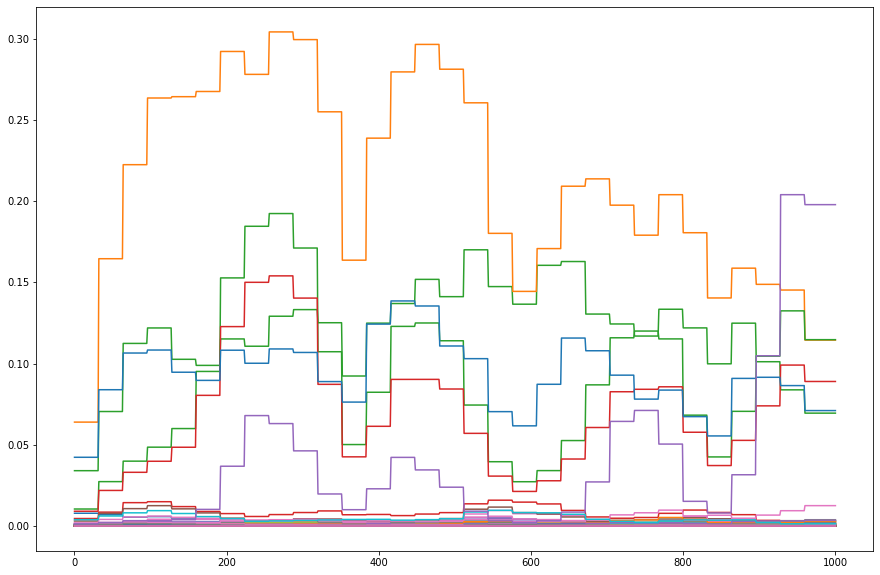

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for i in range (527):
  plt.plot(framewise_output[0,:,i])

In [90]:
framewise_output.ndim

3

In [26]:
import numpy as np

In [1]:
def quantize_prediction(pred, threshold=0.1):
  assert pred.ndim == 3
  th_pred = (pred > threshold).astype(int)
  diff_pred = np.diff(th_pred, axis=1).transpose(0,2,1)
  onset = np.nonzero(diff_pred==1)
  offset =  np.nonzero(diff_pred==-1)
  events = []
  j = 0
  for i, (batch_id, tag_id, onset_frame) in enumerate(zip(onset[0], onset[1], onset[2])):
    event = {'batch_id': batch_id, 'label':sed.labels[tag_id], 'onset':onset_frame/100}
    if j<len(offset[0]) and batch_id == offset[0][j] and tag_id == offset[1][j]:
      event['offset'] = offset[2][j] / 100
      j += 1
    else:
      event['offset'] = (pred.shape[1]-1) / 100
#       print(len(offset[0]), batch_id,  offset[0][j], tag_id,  offset[1][j] )
    events.append(event)
  return events

quantize_prediction(framewise_output, 0.02)

NameError: name 'framewise_output' is not defined

In [102]:
threshold = 0.1
th_pred = (framewise_output > threshold).astype(int)
diff_pred = np.diff(th_pred, axis=1)

onset = np.nonzero(np.diff(th_pred, axis=1).transpose(0,2,1)==1)
offset =  np.nonzero(np.diff(th_pred, axis=1).transpose(0,2,1)==-1)

In [103]:
onset[1], onset[2]

(array([ 72,  72,  72,  72, 111, 112, 112, 112, 112, 113, 510, 510, 510,
        510, 514]),
 array([ 63, 191, 383, 863,  31, 191, 415, 703, 895, 191,  63, 191, 383,
        639, 895]))

In [104]:
offset[1], offset[2]

(array([ 72,  72,  72,  72, 112, 112, 112, 113, 510, 510, 510, 510]),
 array([159, 351, 831, 927, 351, 511, 799, 319, 127, 319, 543, 703]))

In [83]:
events = []
j = 0
for i, (batch_id, tag_id, onset_frame) in enumerate(zip(onset[0], onset[1], onset[2])):
  event = {'batch_id': batch_id, 'label':sed.labels[tag_id], 'onset':onset_frame/100}
  if j<len(offset[0]) and batch_id == offset[0][j] and tag_id == offset[1][j]:
    event['offset'] = offset[2][j]
    j += 1
  else:
    event['offset'] = 10.0
    
  events.append(event)

In [84]:
events

[{'batch_id': 0, 'label': 'Animal', 'onset': 63, 'offset': 159},
 {'batch_id': 0, 'label': 'Animal', 'onset': 191, 'offset': 351},
 {'batch_id': 0, 'label': 'Animal', 'onset': 383, 'offset': 831},
 {'batch_id': 0, 'label': 'Animal', 'onset': 863, 'offset': 927},
 {'batch_id': 0, 'label': 'Bird', 'onset': 31, 'offset': 1001},
 {'batch_id': 0,
  'label': 'Bird vocalization, bird call, bird song',
  'onset': 191,
  'offset': 351},
 {'batch_id': 0,
  'label': 'Bird vocalization, bird call, bird song',
  'onset': 415,
  'offset': 511},
 {'batch_id': 0,
  'label': 'Bird vocalization, bird call, bird song',
  'onset': 703,
  'offset': 799},
 {'batch_id': 0,
  'label': 'Bird vocalization, bird call, bird song',
  'onset': 895,
  'offset': 1001},
 {'batch_id': 0, 'label': 'Chirp, tweet', 'onset': 191, 'offset': 319},
 {'batch_id': 0,
  'label': 'Outside, rural or natural',
  'onset': 63,
  'offset': 127},
 {'batch_id': 0,
  'label': 'Outside, rural or natural',
  'onset': 191,
  'offset': 319},

In [87]:
import IPython.display as ipd
ipd.Audio(audio, rate=32000)

In [1]:
from panns_inference import AudioTagging, SoundEventDetection
import numpy as np
import argparse
from pathlib import Path
import torchaudio
from torch.utils.data import DataLoader
import torch
import json


In [2]:
class AudioSet:
  def __init__(self, path, sr=32000) -> None:
    self.path = Path(path)
    self.wav_list = sorted(list(self.path.rglob('*.wav')))
    self.sr = sr

  def __len__(self):
    return len(self.wav_list)
  
  def __getitem__(self, idx):
    wav_path = self.wav_list[idx]
    audio, sr = torchaudio.load(wav_path)
    audio = audio.mean(0)
    if sr != self.sr:
      audio = torchaudio.functional.resample(audio, sr, self.sr)
    return audio


def pad_collate(raw_batch):
  lens = [len(x) for x in raw_batch]
  max_len = max(lens)
  output = torch.zeros(len(raw_batch), max_len)

  for i, sample in enumerate(raw_batch):
    output[i, :len(sample)] = sample
  
  return output, lens



def quantize_prediction(pred, lens, threshold=0.1, shifted_index=0):
  assert pred.ndim == 3
  th_pred = (pred > threshold).astype(int)
  th_pred = np.concatenate([np.zeros([th_pred.shape[0], 1, th_pred.shape[2]]), th_pred], axis=1) # add initial step
  diff_pred = np.diff(th_pred, axis=1).transpose(0,2,1)
  onset = np.nonzero(diff_pred==1)
  offset =  np.nonzero(diff_pred==-1)
  events_of_piece = []
  total_events = []
  j = 0
  prev_batch_id = -1

  for i, (batch_id, tag_id, onset_frame) in enumerate(zip(onset[0], onset[1], onset[2])):
    event = {'data_id': int(batch_id + shifted_index), 'label':sed.labels[tag_id], 'onset': float(onset_frame/100)}
    if j<len(offset[0]) and batch_id == offset[0][j] and tag_id == offset[1][j]:
      event['offset'] = float(offset[2][j] / 100)
      j += 1
    else:
      event['offset'] = lens[batch_id] / 32000
#       print(len(offset[0]), batch_id,  offset[0][j], tag_id,  offset[1][j] )
    event['confidence'] = max(pred[batch_id, onset_frame:int(event['offset']*100), tag_id])
  
    if batch_id == prev_batch_id:
      events_of_piece.append(event)
    else:
      if events_of_piece != []:
        events_of_piece = retain_one_event_per_tag(events_of_piece)
        total_events.append(events_of_piece)
      events_of_piece = []
    prev_batch_id = batch_id
  if events_of_piece != []:
    events_of_piece = retain_one_event_per_tag(events_of_piece)
    total_events.append(events_of_piece)

  return total_events

def retain_one_event_per_tag(events):
  '''
  events = list of tag events
  '''
  unique_tags = list(set([x['label'] for x in events]))
  outputs = []
  for tag in unique_tags:
    selected_events = [x for x in events if x['label']==tag]
    scores = [x['confidence'] * (x['offset']-x['onset']) for x in selected_events]
    max_id = scores.index(max(scores))
    outputs.append(selected_events[max_id])
  return outputs



In [3]:
dataset = AudioSet('/home/teo/userdata/nia_dataset')

data_loader = DataLoader(dataset, batch_size=16, collate_fn=pad_collate, pin_memory=True, num_workers=2)
sed = SoundEventDetection(checkpoint_path=None, device='cuda')
pred = []

for i, batch in enumerate(data_loader):
  audio, lens = batch
  framewise_output = sed.inference(audio)

  pred += quantize_prediction(framewise_output, lens, shifted_index= i * data_loader.batch_size, threshold=0.1)
  break


Checkpoint path: /home/teo/panns_data/Cnn14_DecisionLevelMax.pth
GPU number: 1


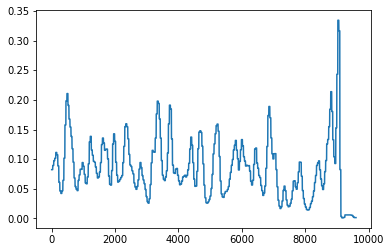

In [11]:
import matplotlib.pyplot as plt

plt.plot(framewise_output[0, :, 137])

In [48]:
sed.labels[137]

'Music'

In [17]:
target = framewise_output[0, :, 137]

In [45]:
import torch

atensor = torch.Tensor(target)
conv = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=501, bias=False, padding=250)
conv.weight.data = torch.ones_like(conv.weight)
conv.weight.data

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [46]:
output = conv(atensor.unsqueeze(0))

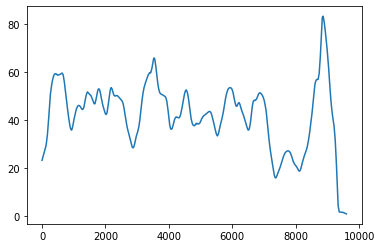

In [47]:
plt.plot(output.detach()[0])

In [29]:
target[0:100].sum()

9.034536

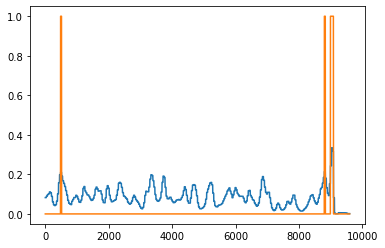

In [27]:
plt.plot(target)
plt.plot(target > 0.2)

In [25]:
np.where(np.diff(target>0.1, axis=0)==1)

(array([  95,  191,  383,  671, 1183, 1311, 1567, 1791, 1919, 2015, 2271,
        2463, 3167, 3455, 3647, 3807, 4351, 4447, 4607, 4767, 5087, 5311,
        5727, 5887, 5951, 6079, 6399, 6463, 6783, 7071, 8671, 8927, 8959,
        9087]),)

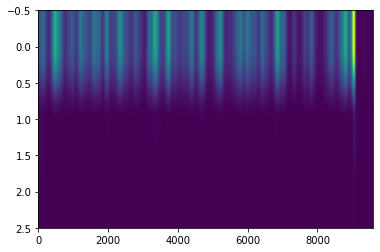

In [10]:
plt.imshow(framewise_output[0,:,137:140].T, aspect='auto')

In [9]:
pred

[[{'data_id': 0,
   'label': 'Gunshot, gunfire',
   'onset': 79.68,
   'offset': 81.92,
   'confidence': 0.1713518},
  {'data_id': 0,
   'label': 'Machine gun',
   'onset': 80.0,
   'offset': 81.92,
   'confidence': 0.15658519},
  {'data_id': 0,
   'label': 'Music',
   'onset': 3.84,
   'offset': 6.72,
   'confidence': 0.2108428}],
 [{'data_id': 1,
   'label': 'Electronic music',
   'onset': 9.28,
   'offset': 79.36,
   'confidence': 0.27731282},
  {'data_id': 1,
   'label': 'Dubstep',
   'onset': 13.12,
   'offset': 16.0,
   'confidence': 0.14843985}],
 [{'data_id': 2,
   'label': 'Electronic music',
   'onset': 77.76,
   'offset': 78.72,
   'confidence': 0.113106966},
  {'data_id': 2,
   'label': 'Music',
   'onset': 28.8,
   'offset': 84.8,
   'confidence': 0.33777913}],
 [{'data_id': 3,
   'label': 'Explosion',
   'onset': 91.84,
   'offset': 92.8,
   'confidence': 0.18218252},
  {'data_id': 3,
   'label': 'Wind noise (microphone)',
   'onset': 9.6,
   'offset': 10.88,
   'confiden

In [118]:
def jsonify(event_labels, dataset):
  '''
  event_labels (list of dict):
    each item has {'data_id': int, 'label': str, 'onset': float, 'offset': float}

  dataset (AudioSet)
  
  '''
  json_list = []

  for piece_event in event_labels:
    event_id = piece_event[0]['data_id']
    sample_path = str(dataset.wav_list[event_id].relative_to(dataset.path))
    sample_path = '/data/local-files/?d=nia_dataset/'+sample_path

    annotations =[{'id': 1,
                    'result': [{
                                "value":{"start":event['onset'],"end":event['offset'],"labels":[event['label']]},
                                "from_name":"label",
                                "to_name":"audio",
                                "type":"labels",
                              } for event in piece_event]}]
    json_event = {'id':event_id, 'annotations': annotations, 'data': {'audio': sample_path}, }
    json_list.append(json_event)

  return json_list

In [119]:
jsonified_pred = jsonify(pred, dataset)
with open("test.json", "w") as json_file:
  json.dump(jsonified_pred, json_file)

SyntaxError: invalid syntax (1180289591.py, line 1)

In [41]:
import distinctipy

N = len(sed.labels)
colors = distinctipy.get_colors(N)

In [53]:

for i, label_name in enumerate(sed.labels):
  label_str = f'<Label value="{label_name}" background="#{rgb2hex(*colors[i])}"/>'
  print(label_str)


<Label value="Speech" background="#0bfd1f"/>
<Label value="Male speech, man speaking" background="#ff00ff"/>
<Label value="Female speech, woman speaking" background="#007fff"/>
<Label value="Child speech, kid speaking" background="#ff7f00"/>
<Label value="Conversation" background="#7f3f7f"/>
<Label value="Narration, monologue" background="#57f7db"/>
<Label value="Babbling" background="#c1f70e"/>
<Label value="Speech synthesizer" background="#d9010e"/>
<Label value="Shout" background="#4d8501"/>
<Label value="Bellow" background="#1200de"/>
<Label value="Whoop" background="#e77ff1"/>
<Label value="Yell" background="#099c7d"/>
<Label value="Battle cry" background="#a2bb83"/>
<Label value="Children shouting" background="#8c42fd"/>
<Label value="Screaming" background="#fa348d"/>
<Label value="Whispering" background="#742d01"/>
<Label value="Laughter" background="#003f7f"/>
<Label value="Baby laughter" background="#ffff7f"/>
<Label value="Giggle" background="#37ec7a"/>
<Label value="Snicker"

In [43]:
len(colors)

527

In [47]:
def rgb2hex(r, g, b):
  return '%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

'0bfd1f'